In [167]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interpolate
from datetime import datetime
import math

In [168]:
###################################################################################
###         convert dates and times of manual controls to timestamps            ###
###################################################################################

year = 2021
month = 5
day = [5, 5, 6, 7, 8, 9, 10, 11, 13, 18]
hour = [0, 20, 10, 8, 10, 13, 9, 16, 11, 12]
minutes = [13, 13, 46, 27, 40, 20, 0, 24, 50,15]
seconds = 0
timestamps = []

if len(day) == len(hour) == len(minutes):
    for i in range(len(day)):
        time = datetime(year, month, day[i], hour[i], minutes[i], seconds)
        timestamp = time.timestamp()
        timestamps.append(timestamp)
        print(time, 'hat den Timestamp', timestamp)

else:
    print('ungleiche Zahl an Tagen, Stunden & Minuten')

timestamps = np.array(timestamps)

#######################################################################
###         list of wort rest in beer (manual messurement)          ###
#######################################################################

wort_rest = [11.9, 11.5, 11.2, 10.2, 8.6, 7.1, 5.6, 3.8, 3.2, 2.9]
print(len(wort_rest))                                                           # prüfe, dass gleich viele Zeitpunkte und
print(len(timestamps))                                                          # Messungen für spätere Interpolation vorhanden sind

2021-05-05 00:13:00 hat den Timestamp 1620166380.0
2021-05-05 20:13:00 hat den Timestamp 1620238380.0
2021-05-06 10:46:00 hat den Timestamp 1620290760.0
2021-05-07 08:27:00 hat den Timestamp 1620368820.0
2021-05-08 10:40:00 hat den Timestamp 1620463200.0
2021-05-09 13:20:00 hat den Timestamp 1620559200.0
2021-05-10 09:00:00 hat den Timestamp 1620630000.0
2021-05-11 16:24:00 hat den Timestamp 1620743040.0
2021-05-13 11:50:00 hat den Timestamp 1620899400.0
2021-05-18 12:15:00 hat den Timestamp 1621332900.0
10
10


In [169]:
###################################################
###         read all data form log-file         ###
###################################################

file_data = 'C:\\Users\Jan\GitRepos\data\Sud1.json'

time=[]
pressure=[]
airflow=[]
with open (file_data) as f:
    for line in f:
        fermentation = json.loads(line)
        time.append(fermentation['Timestamp'])
        pressure_dict=fermentation['pressure']
        pressure.append(pressure_dict['bar'])
        airflow_dict = fermentation['airflow']
        airflow.append(airflow_dict['flow'])

###########################################################
###         transofrm data into numpy arrays            ###
###########################################################

time = np.array(time)
time = np.multiply(0.001, time).round(decimals=0)   # transform timestamps from milliseconds to seconds
pressure = np.array(pressure)
airflow = np.array(airflow)

print('time shape:', time.shape)
print('pressure shape:', pressure.shape)
print('airflow shape:', airflow.shape)

time shape: (270352,)
pressure shape: (270352,)
airflow shape: (270352,)


In [170]:
####################################################################################
###         delete first values of arrays before start of fermentation           ###
####################################################################################

time = time[38773:]
pressure = pressure[38773:]
airflow = airflow[38773:]
print(time[0])                                      # prüfe, dass wirklich mit richtigem timestamp gestartet wird

time = time.clip(min=0)                             # set negativ values to zero
pressure = pressure.clip(min=0)                     # set negativ values to zero
airflow[airflow < 20] = 0                           # set values smaller than 20 to zero

print('time shape:', time.shape)
print('pressure shape:', pressure.shape)
print('airflow shape:', airflow.shape)

1620166381.0
time shape: (231579,)
pressure shape: (231579,)
airflow shape: (231579,)


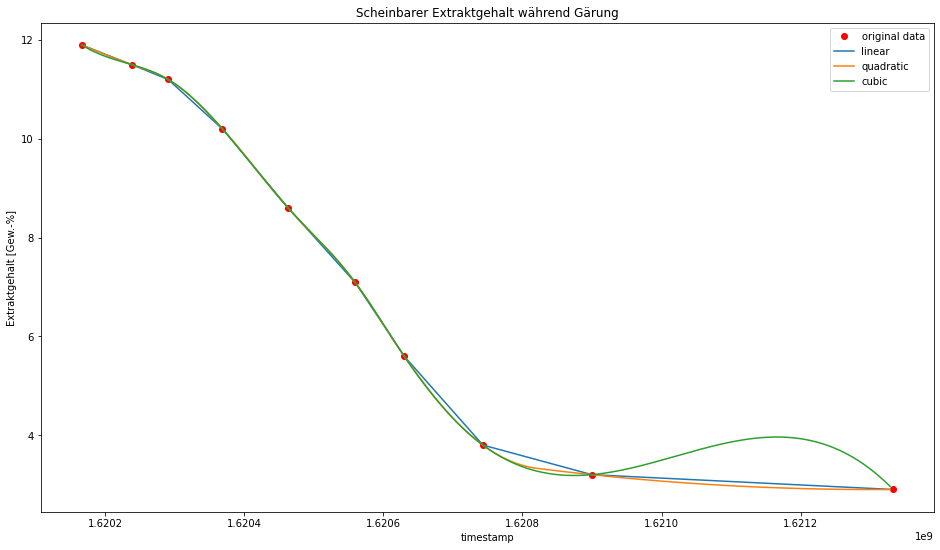

In [171]:
#######################################################
###         interpolation for wort values           ###
#######################################################

plt.figure(figsize=(16,9))
plt.title('Scheinbarer Extraktgehalt während Gärung')
plt.plot(timestamps, wort_rest, 'ro', label='original data')

for kind in ['linear', 'quadratic', 'cubic']:
    f = interpolate.interp1d(timestamps, wort_rest, kind=kind)          # versch. Interpolation der gemessenen Werte
    plt.plot(time, f(time), label=kind)                                 # interpolierter Wert für jeden Zeitpunkt über die Zeit darstellen

plt.xlabel('timestamp')
plt.ylabel('Extraktgehalt [Gew.-%]')
plt.legend()
plt.show()

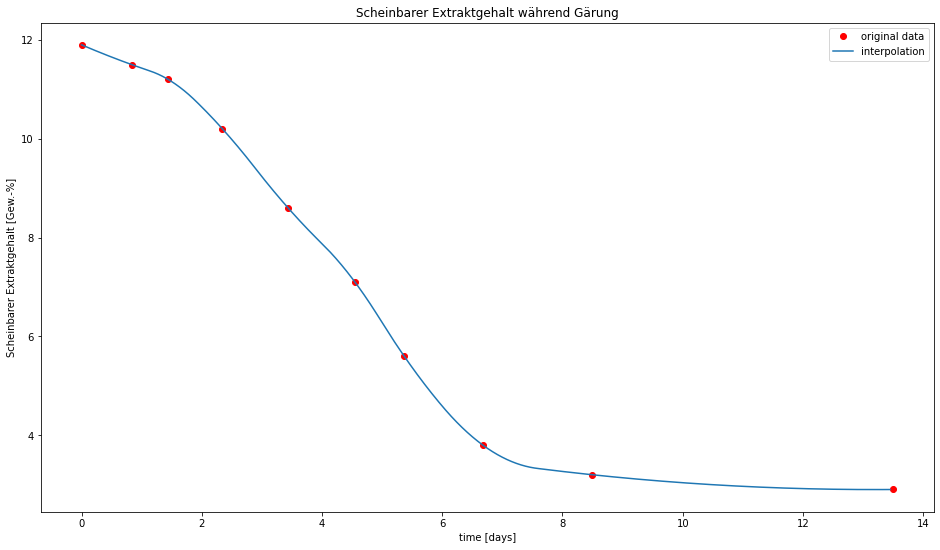

In [172]:
#############################################################
###         final interpolation for wort values           ###
#############################################################

time_seconds = time - 1620166381                                               # first timestamp should be zero
time_days = np.multiply(1.157416667e-5, time_seconds).round(decimals=3)

# ----------------------------------------------------------------

timestamps_seconds = timestamps - 1620166381                                               # timestamps should have same scale as time
timestamps_days = np.multiply(1.157416667e-5, timestamps_seconds).round(decimals=3)
# ----------------------------------------------------------------

f = interpolate.interp1d(timestamps_days, wort_rest, kind='quadratic')

plt.figure(figsize=(16,9))
plt.title('Scheinbarer Extraktgehalt während Gärung')
plt.plot(timestamps_days, wort_rest, 'ro', label='original data')
plt.plot(time_days, f(time_days), label='interpolation')
plt.xlabel('time [days]')
plt.ylabel('Scheinbarer Extraktgehalt [Gew.-%]')
plt.legend()
plt.show()

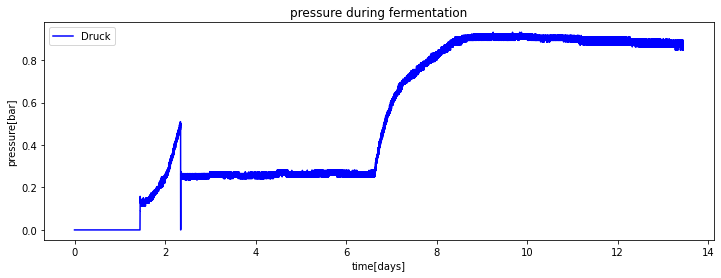

In [173]:
plt.figure(figsize=(12,4))
plt.title('pressure during fermentation')
plt.plot(time_days,pressure, color="blue", label="Druck")
plt.xlabel('time[days]')
plt.ylabel('pressure[bar]')
plt.legend()
plt.show()

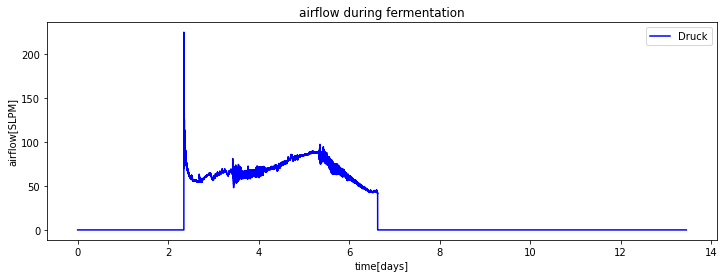

In [174]:
plt.figure(figsize=(12,4))
plt.title('airflow during fermentation')
plt.plot(time_days, airflow, color="blue", label="Druck")
plt.xlabel('time[days]')
plt.ylabel('airflow[SLPM]')
plt.legend()
plt.show()

In [175]:
#########################################################
###         smoothing of airflow and pressure         ###
#########################################################

kernel_size = 10000
kernel = np.ones(kernel_size) / kernel_size
airflow = np.convolve(airflow, kernel, mode='same')
pressure = np.convolve(pressure, kernel, mode='same')

print('airflow shape:', airflow.shape)
print('pressure shape:', pressure.shape)

#############################################################################
###         calculations with arrays for more detailed input data         ###
#############################################################################

time_seconds = time - 1620166380
time_days = np.multiply(1.157416667e-5, time_seconds).round(decimals=5)

# ----------------------------------------------------------------
airflow = np.multiply(0.08, airflow)
airflow = airflow.round(decimals=5)
airflow_5s = np.multiply(0.0833333333333, airflow).round(decimals=5)        # *(5/60) -> Standart Liter per 5 secondes
airflow_sum = np.cumsum(airflow_5s)                                         # sum up all values of airflow in airflow_sum
airflow_diff = np.diff(airflow_5s)                                          # difference of airflow values to the next one
airflow_diff = np.insert(airflow_diff, 0, 0)                                # insert beginning zero for same size of array

# ----------------------------------------------------------------
pressure = pressure.round(decimals=5)
pressure[156500:] = 0.91

# print(np.amax(pressure))
# print(pressure.argmax(axis=0))
# print(pressure[155062])

##########################################################################################
###         find position of current temperature, set temperature, set pressure        ###
##########################################################################################
 
print(np.where(time==1620238380)[0][0])             # zeigt Position des ersten Wertes an, an dem Soll-Temperatur 10°C und Ist_temperatur 9°C beträgt
print(np.where(time==1620743040)[0][0])             # zeigt Position des ersten Wertes an, an dem Soll-Temperatur 12°C und Soll-Druck 1,4 bar beträgt

print(np.where(time==1620290761)[0][0])             # zeigt Position des ersten Wertes an, an dem Ist-Temperatur 9,5°C beträgt
print(np.where(time==1620368820)[0][0])             # zeigt Position des ersten Wertes an, an dem Ist-Temperatur 10°C beträgt
print(np.where(time==1620899399)[0][0])             # zeigt Position des ersten Wertes an, an dem Ist-Temperatur 12°C beträgt

#######################################################################################################
###         create arrays for current temperature, temperature setpoint & pressure setpoint         ###
#######################################################################################################

temperature = np.full_like(time_days, 1)
temperature[:14342] = 20
temperature[14342:24766] = 9
temperature[24766:40300] = 9.5
temperature[40300:146003] = 10
temperature[146003:] = 12

# ----------------------------------------------------------------

temperature_set = np.full_like(time_days, 1)
temperature_set[:14342] = 8
temperature_set[14342:114832] = 10
temperature_set[114832:] = 12

# ----------------------------------------------------------------

pressure_set = np.full_like(time_days, 0)
pressure_set[114832:] = 1.4

airflow shape: (231579,)
pressure shape: (231579,)
14342
114832
24766
40300
146003


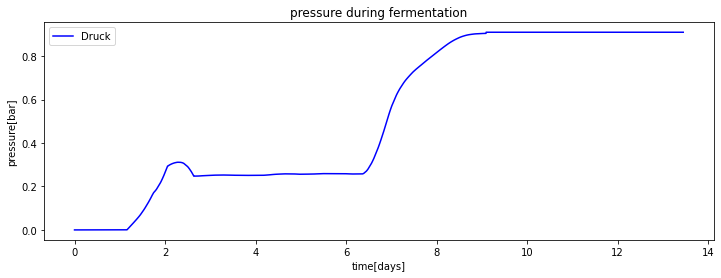

In [176]:
plt.figure(figsize=(12,4))
plt.title('pressure during fermentation')
plt.plot(time_days,pressure, color="blue", label="Druck")
plt.xlabel('time[days]')
plt.ylabel('pressure[bar]')
plt.legend()
plt.show()

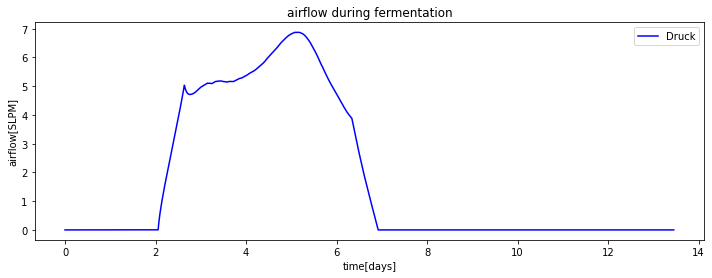

In [177]:
plt.figure(figsize=(12,4))
plt.title('airflow during fermentation')
plt.plot(time_days, airflow, color="blue", label="Druck")
plt.xlabel('time[days]')
plt.ylabel('airflow[SLPM]')
plt.legend()
plt.show()

In [178]:
###########################################
###         Extraktberechnung           ###
###########################################

# ----------------------------------------------------------------
#           create arrays full of ones

flow_mass = np.full_like(time_days, 1)
flow_mass_total = np.full_like(time_days, 1)
air_mass = np.full_like(time_days, 1)
gas_in_liquid_mass = np.full_like(time_days, 1)
total_co2_mass = np.full_like(time_days, 1)
extract_mass_converted = np.full_like(time_days, 1)
extraktgehalt = np.full_like(time_days, 1)
extraktgehalt_scheinbar_1 = np.full_like(time_days, 1)
vergaerungsgrad = np.full_like(time_days, 1)

flow_mass_calc = np.full_like(time_days, 1)
flow_mass_total_calc = np.full_like(time_days, 1)
airflow_5s_calc = np.full_like(time_days, 1)
extract_mass_converted_calc = np.full_like(time_days, 1)
vergaerungsgrad_calc = np.full_like(time_days, 1)
extraktgehalt_calc = np.full_like(time_days, 1)
extraktgehalt_scheinbar_interp = np.full_like(time_days, f(time_days))

# ----------------------------------------------------------------
#           constants for fermentation calculation

SW = 11.9                                           # Stammwürze [°P]
wuerze_mass = 2096                                  # Masse der Würze vor der Gärung [kg]
wuerze_volume = 2                                   # Würzevloumen [m^3]
air_volume = 1000                                   # Luftvolumen [l]
extract_mass_start = SW * wuerze_mass / 100         # Startextrakt in [kg] aus Stammwürze und Masse der Würze
mol_mass = 44.01                                    # Molare Masse von CO2 in [g/mol]
henry_const = 0.0338                                # Henry-Konstante für CO2 [mol/(l*bar)]

# ----------------------------------------------------------------------------------------
#           loop over every step (every 5 seconds) during fermantation

for i in range(len(extraktgehalt)):

    temperature_kelvin = temperature[i] + 273.15                                        # Temperatur [K]

    # ---------- ausströmendes CO2 ----------------------------------------------------------------------------------------------------------------
    # density = (pressure[i] * 100000) / (188.9 * (temperature_kelvin))                   # Dichte aus iG-Gesetz [kg/m^3] (100000 - Umrechnung Pascal, 188.9 - Gaskonstante CO2)
    # density = (pressure[i] * 100000) / (188.9 * 273.15)
    density = 1.98
    flow_mass[i] = airflow_5s[i] * density * 0.001                                      # Masse des Durchfluss der letzten 5s [kg]
    if i == 0:
        flow_mass_total[i] = flow_mass[i]
    else:    
        flow_mass_total[i] = flow_mass_total[i-1] + flow_mass[i]                        # gesamtes ausgeströmtes CO2 [kg]
    
    # ---------- im Bier gelöstes CO2 -------------------------------------------------------------------------------------------------------------
    temp_compensation = math.exp(2400*((1/temperature_kelvin) - (1/298.15)))         # Temperaturkompensation für Henrygesetz errechnen
    henry_coefficient = henry_const*temp_compensation                                 # Henry-Koeffizient für CO2 [mol/(l*bar)]
    CO2__concentration = henry_coefficient*pressure[i]                                # Stoffkonzentration in Flüssigkeit über Henry-Gesetz [mol/l]
    gas_in_liquid_mass[i] = mol_mass * wuerze_volume * CO2__concentration               # CO2 im Bier gelöst [kg]

    # ---------- im Tank über dem Bier stehendes CO2 ----------------------------------------------------------------------------------------------
    air_mass[i] = (pressure[i]*100000*air_volume*0.001)/(188.9*temperature_kelvin)      # CO2 im Tank iG-Gesetz [kg] (Beachte Umrechnung bar -> Pa, l -> m^3)
    
    # ---------- GESAMT ---------------------------------------------------------------------------------------------------------------------------
    total_co2_mass[i] = flow_mass_total[i] + air_mass[i] + gas_in_liquid_mass[i]                                        # gesamt erzeugtes CO2 [kg]
    extract_mass_converted[i] = total_co2_mass[i] * 2.1605                                                             # umgesetzter Extrakt [kg]
    vergaerungsgrad[i] = extract_mass_converted[i] / extract_mass_start
    extraktgehalt[i] = SW - (vergaerungsgrad[i] * SW)
    # extraktgehalt[i] = (extract_mass_start - extract_mass_converted[i]) * 100 / (wuerze_mass - (flow_mass_total[i] + air_mass[i]))      
    extraktgehalt_scheinbar_1[i] = (extraktgehalt[i] - (0.1808*SW))/0.8192                                                 # scheinbarer Extraktgehalt [°P]

    # ---------- umgekehrte Berechnung des ausströmenden CO2s -------------------------------------------------------------------------------------
    extraktgehalt_calc[i] = (extraktgehalt_scheinbar_interp[i]*0.8192) + (0.1808*SW)                # Umrechnung aus Brauwelt: wahr <--> scheinbar
    vergaerungsgrad_calc[i] = (SW - extraktgehalt_calc[i]) / SW
    extract_mass_converted_calc[i] = vergaerungsgrad_calc[i] * extract_mass_start
    flow_mass_total_calc[i] = (extract_mass_converted_calc[i] / 2.1605) - air_mass[i] - gas_in_liquid_mass[i]

    if i == 0:
        flow_mass_calc[i] = flow_mass_total_calc[i]
    else:    
        flow_mass_calc[i] = flow_mass_total_calc[i] - flow_mass_total_calc[i-1]

    airflow_5s_calc[i] = flow_mass_calc[i]/(density*0.001)

print('mass extract before fermantation:', extract_mass_start, 'kg \n')
print('mass of total CO2 flow (outside tank) after fermantation:', flow_mass_total[-1], 'kg')
print('mass of CO2 above liquid in tank:', air_mass[-1], 'kg')
print('mass of CO2 in liquid after fermantation:', gas_in_liquid_mass[-1], 'kg')
print('total mass of CO2 after fermantation:', total_co2_mass[-1], 'kg')
print('Extraktgehalt Start:', extraktgehalt[0], '°P')
print('Extraktgehalt Ende:', extraktgehalt[-1], '°P')
print('Extraktgehalt scheinbar Start:', extraktgehalt_scheinbar_1[0], '°P')
print('Extraktgehalt scheinbar Ende:', extraktgehalt_scheinbar_1[-1], '°P')
print('Extrakt umgesetzt:',extract_mass_converted[-1], 'kg \n')

print('ausgeströmtes Gas-Gewicht gesamt:',flow_mass_total_calc[-1], 'kg')
print('Extraktgehalt berechnet Start:', extraktgehalt_calc[0], '°P')
print('Extraktgehalt berechnet Ende:', extraktgehalt_calc[-1], '°P')
print('Extraktgehalt scheinbar Start:', extraktgehalt_scheinbar_interp[0], '°P')
print('Extraktgehalt scheinbar Ende:', extraktgehalt_scheinbar_interp[-1], '°P \n')

mass extract before fermantation: 249.424 kg 

mass of total CO2 flow (outside tank) after fermantation: 65.66350323059989 kg
mass of CO2 above liquid in tank: 1.6894138819881284 kg
mass of CO2 in liquid after fermantation: 3.9076739226364197 kg
total mass of CO2 after fermantation: 71.26059103522444 kg
Extraktgehalt Start: 11.9 °P
Extraktgehalt Ende: 4.554651386851031 °P
Extraktgehalt scheinbar Start: 11.9 °P
Extraktgehalt scheinbar Ende: 2.933509993714637 °P
Extrakt umgesetzt: 153.9585069316024 kg 

ausgeströmtes Gas-Gewicht gesamt: 65.93290027748559 kg
Extraktgehalt berechnet Start: 11.899995731093487 °P
Extraktgehalt berechnet Ende: 4.526882669303485 °P
Extraktgehalt scheinbar Start: 11.899994788932478 °P
Extraktgehalt scheinbar Ende: 2.8996126334271057 °P 



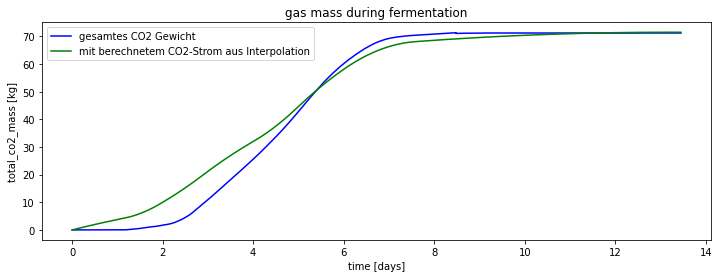

In [179]:
plt.figure(figsize=(12,4))
plt.title('gas mass during fermentation')
plt.plot(time_days, total_co2_mass, color="blue", label="gesamtes CO2 Gewicht")
plt.plot(time_days, (flow_mass_total_calc + air_mass + gas_in_liquid_mass), color="green", label="mit berechnetem CO2-Strom aus Interpolation")
plt.xlabel('time [days]')
plt.ylabel('total_co2_mass [kg]')
plt.legend()
plt.show()

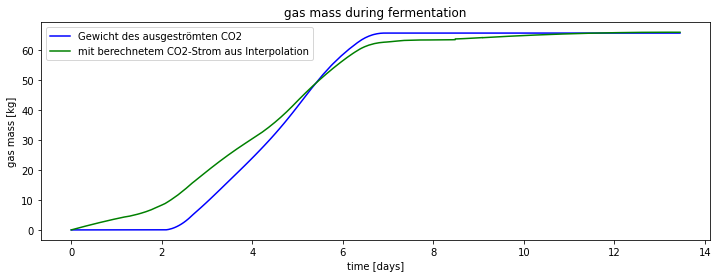

In [180]:
plt.figure(figsize=(12,4))
plt.title('gas mass during fermentation')
plt.plot(time_days, flow_mass_total, color="blue", label="Gewicht des ausgeströmten CO2")
plt.plot(time_days, flow_mass_total_calc, color="green", label="mit berechnetem CO2-Strom aus Interpolation")
plt.xlabel('time [days]')
plt.ylabel('gas mass [kg]')
plt.legend()
plt.show()

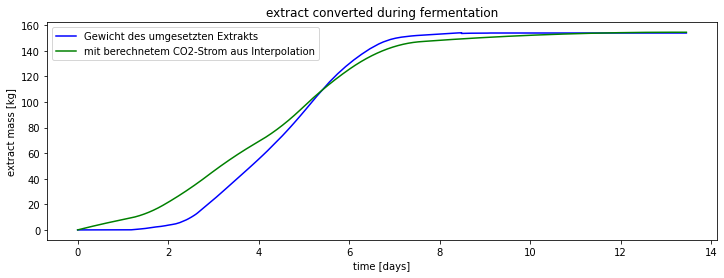

In [181]:
plt.figure(figsize=(12,4))
plt.title('extract converted during fermentation')
plt.plot(time_days, extract_mass_converted, color="blue", label="Gewicht des umgesetzten Extrakts")
plt.plot(time_days, extract_mass_converted_calc, color="green", label="mit berechnetem CO2-Strom aus Interpolation")
plt.xlabel('time [days]')
plt.ylabel('extract mass [kg]')
plt.legend()
plt.show()

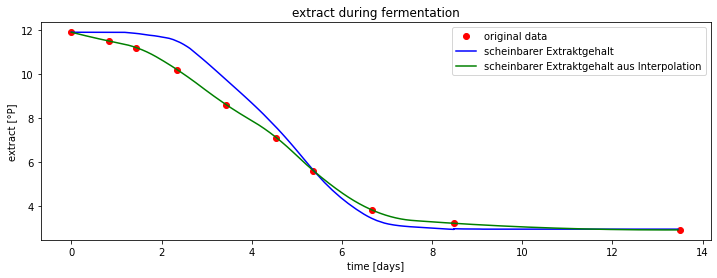

In [182]:
plt.figure(figsize=(12,4))
plt.title('extract during fermentation')
plt.plot(timestamps_days, wort_rest, 'ro', label='original data')
plt.plot(time_days, extraktgehalt_scheinbar_1, color="blue", label="scheinbarer Extraktgehalt")
plt.plot(time_days, extraktgehalt_scheinbar_interp, color="green", label="scheinbarer Extraktgehalt aus Interpolation")
plt.xlabel('time [days]')
plt.ylabel('extract [°P]')
plt.legend()
plt.show()

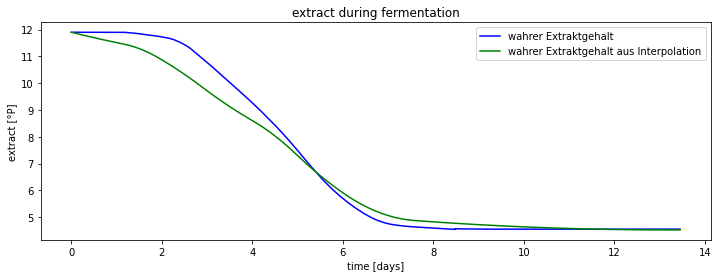

In [183]:
plt.figure(figsize=(12,4))
plt.title('extract during fermentation')
plt.plot(time_days, extraktgehalt, color="blue", label="wahrer Extraktgehalt")
plt.plot(time_days, extraktgehalt_calc, color="green", label="wahrer Extraktgehalt aus Interpolation")
plt.xlabel('time [days]')
plt.ylabel('extract [°P]')
plt.legend()
plt.show()

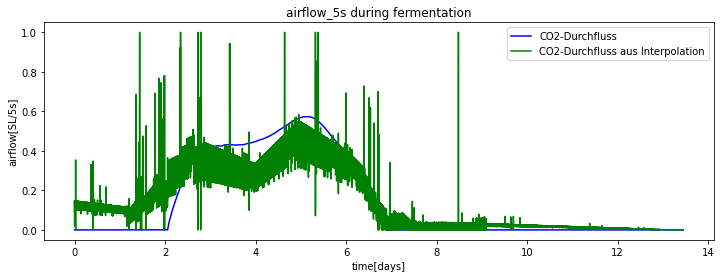

In [185]:
airflow_5s_calc = airflow_5s_calc.clip(min=0, max=1)  

plt.figure(figsize=(12,4))
plt.title('airflow_5s during fermentation')
plt.plot(time_days, airflow_5s, color="blue", label="CO2-Durchfluss")
plt.plot(time_days, airflow_5s_calc, color="green", label="CO2-Durchfluss aus Interpolation")
plt.xlabel('time[days]')
plt.ylabel('airflow[SL/5s]')
plt.legend()
plt.show()